In [1]:
import pandas
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_segments = 19
test_split = 0.3

In [3]:
data = pandas.read_csv('/home/carsten/workspaces/isws/models/predictions_cnn_19k.csv')
num_test_songs = int(len(data)*test_split)

In [4]:
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

In [5]:
data = data.drop(['offset', 'duration', 'blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock'],axis=1)
data.head()

,filename,chroma_stft,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,reggae.00009.wav,0.421017,1679.434736,2024.534270,3466.256905,0.064117,-262.811999,126.180913,11.227370,21.112270,...,-7.607884,9.588800,-6.119003,3.432182,-3.201820,5.127310,-5.069380,2.687792,1.010708,1.363687
1,reggae.00009.wav,0.398483,1875.148780,2227.413557,4031.587601,0.069351,-220.923940,117.441621,4.900961,20.067881,...,-9.459568,11.513007,-3.310631,5.329873,-4.327653,5.566599,-11.337382,3.472775,-2.983636,-0.154111
2,reggae.00009.wav,0.339041,1833.160181,2189.649126,3916.098976,0.067055,-206.509028,117.687803,3.399634,28.708057,...,-12.858065,6.057907,-4.809681,4.935215,-1.390995,4.663574,-9.885031,5.934896,-3.281801,-3.811287
3,reggae.00009.wav,0.344620,1592.273248,2028.807317,3360.189056,0.054104,-232.590603,127.788885,7.052849,31.868343,...,-13.591460,4.414804,-9.697646,4.287556,1.001181,5.695091,-2.546943,5.661095,0.814606,-2.775566
4,reggae.00009.wav,0.378558,1501.627471,1940.269736,3026.676750,0.051956,-243.499728,132.915085,4.320031,20.461475,...,-10.415287,7.210216,-6.188944,4.976785,-0.566316,5.102638,-1.419239,1.561619,1.570058,0.726551


In [6]:
for i in range(len(data.filename)):
    res = data.iat[i,0]
    res = res.split('.')[0]
    data.iat[i,0] = res

In [7]:
genre_list = data.iloc[:, 0]
encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(genre_list)

In [8]:
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, 1:], dtype = float))
np.array(data.iloc[:, 1:])

array([[ 4.21017349e-01,  1.67943474e+03,  2.02453427e+03, ...,
         2.68779176e+00,  1.01070762e+00,  1.36368745e+00],
       [ 3.98482721e-01,  1.87514878e+03,  2.22741356e+03, ...,
         3.47277519e+00, -2.98363629e+00, -1.54110700e-01],
       [ 3.39040828e-01,  1.83316018e+03,  2.18964913e+03, ...,
         5.93489633e+00, -3.28180085e+00, -3.81128662e+00],
       ...,
       [ 5.82671040e-01,  2.81592156e+03,  2.20142615e+03, ...,
         6.15311290e+00, -4.64072449e+00,  6.41197126e+00],
       [ 5.84403050e-01,  2.82644200e+03,  2.19657691e+03, ...,
         6.92371128e+00, -4.59516156e+00,  7.21186444e+00],
       [ 5.70103128e-01,  2.86434960e+03,  2.20523546e+03, ...,
         7.06948791e+00, -4.47092048e+00,  6.61866741e+00]])

In [9]:
X_test = X[:num_test_songs]
X_train = X[num_test_songs:]
y_test = y[:num_test_songs]
y_train = y[num_test_songs:]

In [10]:
from keras import models
from keras import layers

from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [11]:
val_split = int(19000*0.2)
x_val = X_train[:val_split]
partial_x_train = X_train[val_split:]

y_val = y_train[:val_split]
partial_y_train = y_train[val_split:]
x_norm = preprocessing.scale(x_val)

In [12]:
model = models.Sequential()
#model.add(layers.Dense(512, activation='relu', ))

model.add(layers.Dense(35, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(15, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=10),
                 ModelCheckpoint(filepath='./../../../models/ann-model-best.h5', monitor='val_loss', save_best_only=True)]

history = model.fit(partial_x_train,
          partial_y_train,
          epochs=200,
          batch_size=512,
          callbacks=callbacks,
          validation_data=(x_val, y_val))
results = model.evaluate(X_test, y_test)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 9500 samples, validate on 3800 samples
Epoch 1/200
9500/9500 [==============================] - 0s 52us/step - loss: 2.2958 - acc: 0.1523 - val_loss: 2.2282 - val_acc: 0.1832
Epoch 2/200
9500/9500 [==============================] - 0s 9us/step - loss: 2.0988 - acc: 0.2681 - val_loss: 2.1075 - val_acc: 0.2708
Epoch 3/200
9500/9500 [==============================] - 0s 8us/step - loss: 1.9639 - acc: 0.3212 - val_loss: 1.9936 - val_acc: 0.3100
Epoch 4/200
9500/9500 [==============================] - 0s 8us/step - loss: 1.8375 - acc: 0.3477 - val_loss: 1.8884 - val_acc: 0.3224
Epoch 5/200
9500/9500 [==============================] - 0s 9us/step - loss: 1.7282 - acc: 0.3760 - val_loss: 1.7967 - val_acc: 0.3437
Epoch 6/200
9500/9500 [==============================] - 0s 8us/step - loss: 1.6338 - acc: 0.4076 - val_loss: 1.7127 - val_acc: 0.3661
Epoch 7/200
9500/9500

In [13]:
results

[1.338214075816305, 0.5564912280701755]

In [14]:
p = model.predict(X_test)

In [15]:
from sklearn.metrics import confusion_matrix
print(p.argmax(axis=1))
r = []
for int_res in p.argmax(axis=1):
    r.append(genres[int_res])
cm = confusion_matrix(encoder.inverse_transform(y_test), r, genres)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.around(cm, decimals=2)
print(genres)
print(cm)

[8 8 8 ... 5 0 5]
['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
[[0.82 0.01 0.07 0.01 0.   0.06 0.02 0.   0.   0.01]
 [0.   0.87 0.01 0.   0.   0.06 0.   0.   0.06 0.  ]
 [0.08 0.04 0.43 0.03 0.02 0.11 0.01 0.07 0.08 0.13]
 [0.05 0.   0.02 0.37 0.08 0.01 0.08 0.18 0.04 0.18]
 [0.02 0.01 0.01 0.14 0.46 0.01 0.07 0.09 0.13 0.05]
 [0.1  0.07 0.14 0.02 0.04 0.56 0.   0.02 0.04 0.02]
 [0.12 0.   0.01 0.05 0.02 0.02 0.75 0.   0.   0.03]
 [0.01 0.02 0.04 0.02 0.08 0.03 0.   0.73 0.02 0.04]
 [0.02 0.01 0.14 0.03 0.2  0.08 0.01 0.07 0.4  0.03]
 [0.14 0.01 0.09 0.09 0.06 0.06 0.09 0.06 0.08 0.32]]


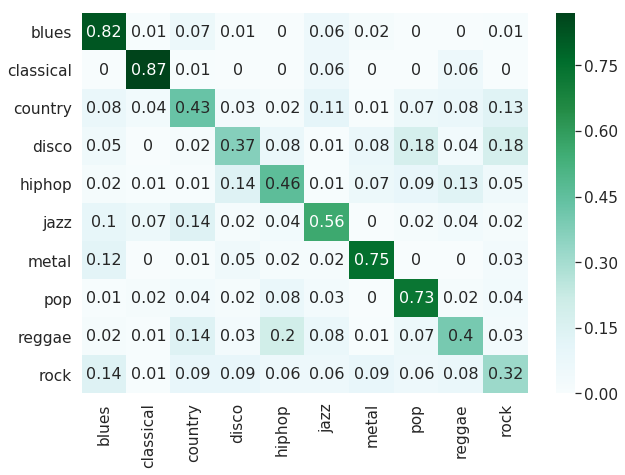

In [16]:
import pandas as pd, seaborn as sn, matplotlib.pyplot as plt
df_cm = pd.DataFrame(cm, genres,
                  genres)
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size

ax=sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}, cmap="BuGn")# font size

In [17]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


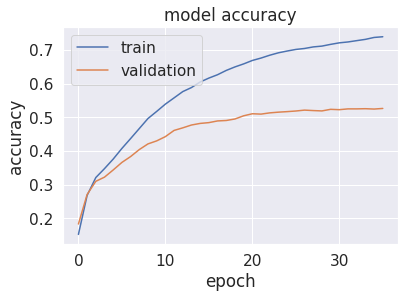

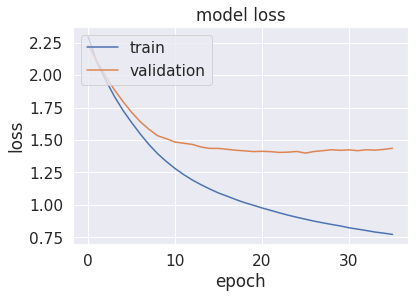

In [18]:
show_summary_stats(history)